# Supervised ML Classifiers for Tanzanian Water-Wells Condition

- **Student  :** Daniel Mwaka
- **Student Pace  :** DSF-FT12
- **Phase :** 3
- **Instructor Name  :** Samuel Karu

## 1 Introduction

### 1.1 Industry Background

Access to clean and reliable water is a fundamental human right and a cornerstone of sustainable development. In many developing nations, including Tanzania, ensuring this access remains a significant challenge. While numerous water points have been established, a substantial portion are in disrepair or have ceased to function altogether, leaving millions without consistent access to this vital resource. The ability to proactively identify and address the issues plaguing these water wells is not just an operational necessity but a critical step towards improving public health, economic stability, and overall quality of life for communities. Understanding the factors that contribute to the failure or disrepair of water infrastructure is therefore paramount, enabling targeted interventions and more effective resource allocation.

This project utilizes three datasets (**trainingset.csv**, **trainingsetlabels.csv**, and **testdata.csv**). 

The datasets are available on https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/.

Utilizing these datasets, the project:

- Identifies potential predictor features in the **trainingset.csv** dataset on a water-well's respective status as captured for each record entry in the **trainingsetlabels.csv** dataset.
- Builds, and tunes three supervised ML classifier models to predict the condition of a water-well (`functional`, `functional needs repair`, or `non functional`).
- Evaluates the performance of three ML classifiers to select the best-fit and most-generalizable model.
- Recommends the selected model for deployment, deduces feasible recommendations and viable next steps to stakeholders.

### 1.2 Problem Statement

The Government of Tanzania and Non-Governmental Organizations (NGOs) face a significant challenge in ensuring reliable access to clean water for their population. A substantial number of established water wells are either in disrepair or have completely failed, leading to water scarcity and its associated negative impacts on public health and socio-economic development. There is currently no effective, data-driven method to accurately predict the condition of water wells, making it difficult to prioritize repair efforts, allocate resources efficiently, and inform the design of new, more resilient water infrastructure. This lack of predictive capability results in reactive maintenance, inefficient resource utilization, and continued widespread water scarcity. The Government of Tanzania and NGOs require a solution that can identify water wells that are in need of repair or are likely to fail, enabling proactive interventions and strategic planning for a sustainable water supply.

### 1.3 Objectives

#### 1.3.1 Goal
To build, train, evaluate and recommend an evidence-based supervised ML classification model for predicting the functional condition of water wells in Tanzania.

#### 1.3.2 Specific Objectives
1. Data Preprocessing.

2. Build a baseline model (**DecisionTreeClassifier**), tune hyperparameters using **GridSearchCV**, evaluate performance and deduce its **_limitations_**.

3. Build an Ensemble Bagging model (**RandomForestClassifier**) and tune _hyperparameters_ using **GridSearchCV**.

4. Build an Ensemble Boosting model (**GradientBoostingClassifier**) and tune _hyperparameters_ using **GridSearchCV**.

5. Utilize each of three models to predict a water-well's functional status for 14,850 entries using preprocessed feature data from **testdata.csv**.

6. Submit each model's prediction (_.csv files_) to the **DrivenData submissions** tab for scoring.  (https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/submissions/)

7. Select the best classification model for deployment based on performance metrics (_on the training, & test set_), and respective prediction accuracy percentage (_**DrivenData submissions** score_).


## 2 Exploratory Data Analysis (EDA)
### 2.1 Data Loading 

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

In [2]:
# Load training datasets
train_features = pd.read_csv("./data/trainingset.csv")
train_labels = pd.read_csv("./data/trainingsetlabels.csv")

# Merge features and labels for EDA
train_df = pd.merge(train_features, train_labels, on="id")

# Display first five rows
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [3]:
# Inspect column attributes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

### 2.2 Data Preprocessing
A modularized preprocessing pipeline is adopted to avoid data leakage.
#### 2.2.1 Define Exog and Endog

In [4]:
# Identify numerical and categorical columns
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('id')
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('status_group')

# Define exogenous (X) and endogenous (y) variables
X = train_df[num_cols + cat_cols]
y = train_df['status_group']

#### 2.2.2 Perform Train-Test Split

In [5]:
# Separate data into a train set and a test set before performing any preprocessing steps
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape : {X_train.shape}")
print(f"X_test shape  : {X_test.shape}")

X_train shape : (47520, 39)
X_test shape  : (11880, 39)


#### 2.2.3 Drop Rendundant and Irrelevant Columns

- The following columns contain redundant information for each entry.

| Picked Column | Redundant Column 1 | Redundant Column 2 |
|----------|----------|----------|
| extraction_type_class | extraction_type | extraction_type_group |
| management_group | scheme_management | management | 
| payment_type | payment |  | 
| water_quality | quality_group | | 
| quantity | quantity_group |  |  
| source_type | source | source_class |  
| waterpoint_type_group | waterpoint_type |  | 

The columns deemed relevant from the training dataset with respect to the scope of this project include:

| Column Name | Data Type | Short Description |
|----------|----------| -------- |
| date_recorded | object | The Year, Month, and Date an entry was recorded (yyyy-mm-dd)  |
| gps_height | int64 | The altitude of the water well location in meters  |
| installer | object | The orgarnization responsible for implementation/ installation |
| basin | object | The geographical basin where the water well is located |
| region | object | The administrative region where the water well is situated |
| population | int64 | The population size served/ used to be served by a water well |
| permit | object | Whether the water well has a legal permit |
| construction_year | int64 | The year the water well was constructed |
| extraction_type_class | object  | The method/ technology used to extract water |
| management_group | object | The group responsible for managing the water well |
| payment_type | object | The payment policy for using the water well |
| water_quality | object | The quality of the water from the well |
| quantity | object | The amount of water available from the well |
| source_type | object | The type of water source |
| waterpoint_type_group | object | The infrustructure used to access water from the well point |

In [6]:
# Create a copy of X_train
X_train_1 = X_train.copy()

# Select relevant columns w.r.t to project scope
picked_cols = [
    'date_recorded',
    'gps_height',
    'installer',
    'basin',
    'region',
    'population',
    'permit',
    'construction_year',
    'management_group', 
    'extraction_type_class', 
    'payment_type', 
    'water_quality', 
    'quantity', 
    'source_type', 
    'waterpoint_type'
]
# Reassign X_train with selected columns 
X_train_1 = X_train_1.loc[:, picked_cols]
X_train_1.head()

,date_recorded,gps_height,installer,basin,region,population,permit,construction_year,management_group,extraction_type_class,payment_type,water_quality,quantity,source_type,waterpoint_type
43360,2011-07-27,0,NaN,Lake Nyasa,Mbeya,0,NaN,0,user-group,gravity,never pay,soft,insufficient,spring,communal standpipe
7263,2011-03-23,2049,ACRA,Rufiji,Iringa,175,True,2008,user-group,gravity,monthly,soft,enough,spring,communal standpipe
2486,2011-03-07,290,Do,Wami / Ruvu,Pwani,2300,False,2010,user-group,handpump,per bucket,salty,insufficient,shallow well,hand pump
313,2011-07-31,0,DWE,Lake Victoria,Kagera,0,True,0,user-group,other,never pay,soft,enough,shallow well,other
52726,2011-03-10,0,Gove,Internal,Dodoma,0,True,0,user-group,motorpump,per bucket,soft,enough,borehole,communal standpipe


#### 2.2.4 Handle Missing Values

In [7]:
# Check for missing values
X_train_1.isna().sum()

date_recorded               0
gps_height                  0
installer                2917
basin                       0
region                      0
population                  0
permit                   2443
construction_year           0
management_group            0
extraction_type_class       0
payment_type                0
water_quality               0
quantity                    0
source_type                 0
waterpoint_type             0
dtype: int64

In [8]:
# Check unique values for the `permit` feature
X_train_1['permit'].unique()

array([nan, True, False], dtype=object)

- The (`permit`) feature is boolean since entries for water-wells with a permit are assigned **True** and those without a permit are assigned **False**. Thus, **nans** in the `permit` column represent missing values.

In [9]:
# Calculate percentage of missing values for the 'permit' column
X_train_1['permit'].isna().mean() * 100

np.float64(5.1409932659932664)

- Entries with nan values for the `permit` column account for 5.14%. Hence, dropping all entries with missing values for the `permit` feature won't have a significant impact on the size of the training set.

In [10]:
X_train_1 = X_train_1.dropna(subset=['permit'])

In [11]:
# Check unique values for the `permit` feature
X_train_1['installer'].unique()

array(['ACRA', 'Do', 'DWE', ..., 'commu', 'DASP', 'Kiliwater r'],
      shape=(1849,), dtype=object)

- The nans in the `installer` column are missing values since the feature's unique values are string identifiers for the different orgarnizations operating in the implementation/ installation of ground water infrustructure. 

In [12]:
# Calculate percentage of missing values for the 'permit' column
X_train_1['installer'].isna().mean() * 100

np.float64(2.1940235596867583)

- Dropping all entries with missing values for the `installer` feature won't have a significant impact on the size of the training set.

In [13]:
X_train_1 = X_train_1.dropna(subset=['installer'])

In [14]:
# Recheck X_train shape after dropping entries with nans
X_train_1.shape
print(f"Training dataset consists of: {X_train_1.shape[0]} rows")
print(f"Training dataset consists of: {X_train_1.shape[1]} columns")

Training dataset consists of: 44088 rows
Training dataset consists of: 15 columns


#### 2.2.5 Feature Engineering

A well's age is an important predictor on it condition. Although the feature is not included in the training.csv dataset; it can be engineered by convering the `date_recorded` variable to datetime and substracting the value from a water-well's `construction_year`.

In [15]:
# Check unique values for `construction_year` feature
X_train_1['construction_year'].unique()

array([2008, 2010,    0, 1986, 1995, 1985, 2009, 1972, 2003, 2006, 1994,
       1996, 1980, 1979, 2005, 1990, 2007, 2004, 2001, 1978, 1977, 1991,
       1999, 1993, 1983, 1997, 2011, 1989, 1998, 2000, 1984, 1982, 1992,
       2012, 1975, 1976, 2002, 1970, 1963, 1968, 1981, 1988, 1987, 2013,
       1973, 1971, 1961, 1974, 1962, 1969, 1960, 1964, 1967, 1966, 1965])

In [16]:
# Drop all row entries with a value of 0 in the column `construction_year`
X_train_1.drop(X_train_1[X_train_1['construction_year'] == 0].index, inplace=True)

In [17]:
# Recheck X_train shape
X_train_1.shape
print(f"Training dataset consists of: {X_train_1.shape[0]} rows")
print(f"Training dataset consists of: {X_train_1.shape[1]} columns")

Training dataset consists of: 29422 rows
Training dataset consists of: 15 columns


In [18]:
# Convert 'date_recorded' to datetime year
X_train_1['date_recorded'] = pd.to_datetime(X_train_1['date_recorded']).dt.year

# Calculate well_age = date_recorded - construction_year
X_train_1['well_age'] = X_train_1['date_recorded'] - X_train_1['construction_year']

In [19]:
# Confirm the Engineered feature accurately captures a well's age 
X_train_1[['date_recorded', 'construction_year', 'well_age']].head()

,date_recorded,construction_year,well_age
7263,2011,2008,3
2486,2011,2010,1
8558,2011,1986,25
2559,2013,1995,18
28603,2013,1985,28


In [20]:
 # Drop 'construction_year' and 'date_recorded' features from X_train
X_train_1 = X_train_1.drop(columns=['construction_year', 'date_recorded'])

In [21]:
# Check descriptive statistics for the engineered `well-age` feature
X_train_1['well_age'].describe()

count    29422.000000
mean        15.233703
std         12.503398
min         -7.000000
25%          4.000000
50%         12.000000
75%         25.000000
max         53.000000
Name: well_age, dtype: float64

- It is impossible for the age of a water-well to be a negative number. The computed negative well-age value is likely due to either an error in an entry's `date_recorded` or `construction_year` columns. 

In [22]:
# Drop all row entries whose values for 'well_age' are less than zero
X_train_1 = X_train_1[X_train_1['well_age'] >= 0]

#### 2.2.6 Multicollinearity Check

- Highly correlated numerical features leads to multicolinearity. Training supervised ML classifiers with highly correlated numerical features increases computational complexity, and elevates the risk for overfitting. 
- Additionally, multicollinearity leads to uncertainity in determining the true contribuction of each feature to predictions.
- Correlation measures are highly sensitive to outliers. Thus, plotting a correlation matrix for the numerical features in X_train will shed insights on highly correlated variables.

In [23]:
# Identify numerical columns after engineering features
X_train_num_cols = X_train_1.select_dtypes(include=[np.number]).columns.tolist()

# Remove outliers
for col in X_train_num_cols:
    lower = X_train_1[col].quantile(0.01)
    upper = X_train_1[col].quantile(0.99)
    X_train_1 = X_train_1[(X_train_1[col] >= lower) & (X_train_1[col] <= upper)]


In [24]:
X_train_num_cols

['gps_height', 'population', 'well_age']

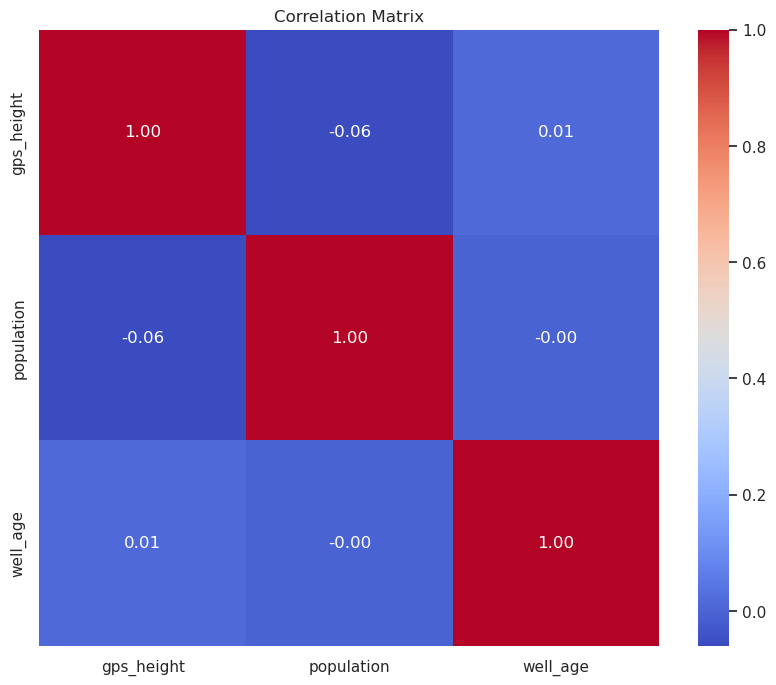

In [25]:
# Plot the correlation matrix
corr = X_train_1[X_train_num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- There is no multicolineariry among the three numerical variables. 
- For the inclusion of the three numerical variables in the features' matrix, they must normalized. 
- The MinMaxScaller is selected because it scales numerical features between 0 and 1. Hence, the scaled numerical features will lie within the same range as the OneHotEncoded dummy variables for categorical features. 

#### 2.2.7 Standardize Numerical Features and One Hot Encode Categorical Features

In [26]:
# Create a copy of the training set
X_train_scaled = X_train_1.copy()

# Initialize StandardScaler
scaler = StandardScaler()

# Fit transform the numerical columns using StandardScaler to normalize the data
X_train_scaled[X_train_num_cols] = scaler.fit_transform(X_train_scaled[X_train_num_cols])

X_train_num_df = pd.DataFrame(X_train_scaled, columns=X_train_num_cols, index=X_train_scaled.index)

X_train_num_df.head()

,gps_height,population,well_age
7263,1.757339,-0.190279,-0.986995
2486,-1.136724,6.676192,-1.152152
8558,0.516791,-0.109497,0.829738
2559,0.878755,-0.271061,0.251686
28603,-1.143305,-0.752522,1.077474


In [27]:
# Identify categorical columns in X_train_scaled
X_train_cat_cols = X_train_scaled.select_dtypes(include=['object']).columns.tolist()
print(X_train_cat_cols)

['installer', 'basin', 'region', 'permit', 'management_group', 'extraction_type_class', 'payment_type', 'water_quality', 'quantity', 'source_type', 'waterpoint_type']


In [28]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit and transform X_train_scaled categorical columns
X_train_ohe = ohe.fit_transform(X_train_scaled[X_train_cat_cols])

# Convert to DataFrame for easier inspection
ohe_feature_names = ohe.get_feature_names_out(X_train_cat_cols)
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_feature_names, index=X_train_scaled.index)

In [29]:
# Concat the normalized numerical features df and the OneHot encoded categorical features df
X_train_final = pd.concat([X_train_num_df, X_train_ohe_df], axis=1)

# Print first five rows of concatenated df
X_train_final.head()

,gps_height,population,well_age,installer_ABASIA,installer_AC,installer_ACRA,installer_ACTION AID,installer_ACTIVE TANK CO,installer_ACTIVE TANK CO LTD,installer_AD,...,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
7263,1.757339,-0.190279,-0.986995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2486,-1.136724,6.676192,-1.152152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8558,0.516791,-0.109497,0.829738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2559,0.878755,-0.271061,0.251686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
28603,-1.143305,-0.752522,1.077474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
# Check X_train_final shape
X_train_final.shape
print(f"Training dataset consists of: {X_train_final.shape[0]} rows")
print(f"Training dataset consists of: {X_train_final.shape[1]} columns")

Training dataset consists of: 28306 rows
Training dataset consists of: 1342 columns


#### 2.2.8 Label Encode Target Variable

In [31]:
# Create a copy of y_train
y_train_1 = y_train.copy()

# Align y_train to X_train_final indices 
y_train_aligned = y_train_1.loc[X_train_final.index]

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform y_train_aligned using LabelEncoder
y_train_enc = le.fit_transform(y_train_aligned)

# Print class distribution of the encoded y_train labels
print(f"Encoded y_train distribution: {np.bincount(y_train_enc)}")

Encoded y_train distribution: [15981  1851 10474]


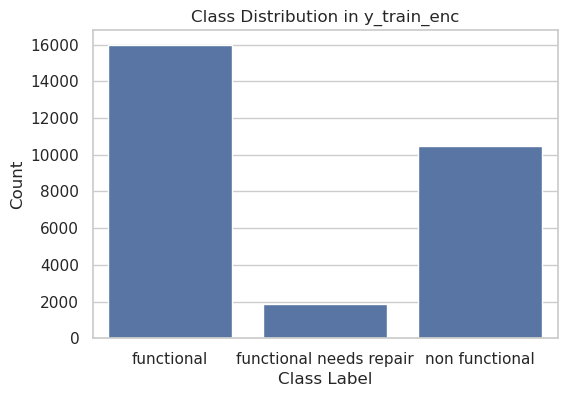

In [32]:
# Visualize class distributions in y_train_enc
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_enc)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution in y_train_enc')
plt.xticks(ticks=[0,1,2], labels=le.classes_)
plt.show()

It is evident the target variable has class imbalance.

- `functional` = 15,981 samples
- `functional needs repair` = 1,851 samples
- `non functional` = 10,474 samples

Training ML classifiers on an unbalanced data can result to a biased model that performs exceptionally well in making predictions for the majority class but poorly for the minority classes. Additionally, it compromises the legibility of standard evaluation measures when comparing the performance of different models to determine the best fit/ most appropriate alternative respective to a specific business problem. For instance, the accuracy metrics can be deceptive since a model's score is skewed upwards if it is able to make accurate predictions for the majority class even if it performs poorly in predicting the minority class. 

#### 2.2.9 Address Class Imbalance
Class Imbalance can be tackled by undersampling the majority classes or creating synthetic samples of the minority classes. Each Technique has unique strengths and potential drawbacks on the quality of the data used to train supervised ML classification models. Both techniques are applied to address class imbalance in the training set. Each technique's results (balanced X_train) are assigned to unique variables to avail selection flexibility on the type of balanced training set that is fit to the models. 

#### Undersampling Technique
The undersampling technique addresses class imbalance in the target variable for the training set by reducing the number of samples in the majority classes to match the number of samples in the minority class. The rationale for the undersampling technique is as follows:

- **Improved Model Generalization:** By balancing the class distribution, the model is encouraged to learn patterns for all classes, not just the majority, leading to better generalization and fairer predictions.
- **Reliable Evaluation Metrics:** Balanced classes ensure that evaluation metrics (such as accuracy, precision, recall, and F1-score) more accurately reflect the model's performance across all classes, rather than being dominated by the majority class.
- **Simplicity and Data Integrity:** Given that the minority class is not extremely small, undersampling avoids the risk of overfitting associated with oversampling techniques (like SMOTE) and maintains the authenticity of the data.

In [33]:
from sklearn.utils import resample

# Combine X_train_final and y_train_enc into a DataFrame for resampling
Xy_train_us = X_train_final.copy()
Xy_train_us['target'] = y_train_enc

# Find the minority class count
min_class_count = Xy_train_us['target'].value_counts().min()

# Separate each class
class_0 = Xy_train_us[Xy_train_us['target'] == 0]
class_1 = Xy_train_us[Xy_train_us['target'] == 1]
class_2 = Xy_train_us[Xy_train_us['target'] == 2]

# Downsample majority classes to match the minority class
class_0_down = resample(class_0, replace=False, n_samples=min_class_count, random_state=42)
class_2_down = resample(class_2, replace=False, n_samples=min_class_count, random_state=42)

# Combine all classes
Xy_balanced_us = pd.concat([class_0_down, class_1, class_2_down])
Xy_balanced_us = Xy_balanced_us.sample(frac=1, random_state=42)  # Shuffle

# Split back into features and target
X_train_balanced_us = Xy_balanced_us.drop('target', axis=1)
y_train_balanced_us = Xy_balanced_us['target']

print("Class distribution of y_train_balanced after undersampling:")
print(y_train_balanced_us.value_counts())
print("------------------------------------------------------------------------")

# Check X_train_balanced_us shape
X_train_balanced_us.shape
print(f"X_train_balanced (undersampling technique) consists of: {X_train_balanced_us.shape[0]} rows")
print(f"X_train_balanced (undersampling technique) consists of: {X_train_balanced_us.shape[1]} columns")

Class distribution of y_train_balanced after undersampling:
target
1    1851
2    1851
0    1851
Name: count, dtype: int64
------------------------------------------------------------------------
X_train_balanced (undersampling technique) consists of: 5553 rows
X_train_balanced (undersampling technique) consists of: 1342 columns


#### SMOTE Technique
The SMOTE technique tackles class imbalance within the target variable of the training set by creating synthetic samples for the minority classes. It identifies data points in the minority class and generates new, similar instances along the line segments connecting minority class samples and their nearest neighbors. The rationale for the SMOTE technique is as follows:

- **Enriched Model Learning:** By synthetically increasing the representation of minority classes, the model gains more diverse data points to learn from, allowing it to better capture the underlying patterns of these classes. This often leads to improved predictive performance for rare events or categories.
- **Reduced Information Loss:** Unlike undersampling, which discards valuable data from the majority classes, SMOTE retains all original data. This can be crucial when the dataset is already small or when every piece of information is considered important.
- **Mitigation of Overfitting Risk:** While simple oversampling methods (like random duplication) can lead to overfitting by merely replicating existing data, SMOTE generates novel, yet realistic, synthetic samples. This helps the model generalize better to unseen data by introducing new variations of the minority class, without simply memorizing existing instances.

In [34]:
from imblearn.over_sampling import SMOTE

# Combine X_train_final and y_train_enc into a DataFrame for resampling
Xy_train_smote = X_train_final.copy()
Xy_train_smote['target'] = y_train_enc

# Separate features and target
X_smote = Xy_train_smote.drop('target', axis=1)
y_smote = Xy_train_smote['target']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced_smote, y_train_balanced_smote = smote.fit_resample(X_smote, y_smote)

print("Class distribution of y_train_balanced after SMOTE:")
print(pd.Series(y_train_balanced_smote).value_counts())
print("------------------------------------------------------------------------")

# Check X_train_balanced shape
print(f"X_train_balanced (SMOTE technique) consists of: {X_train_balanced_smote.shape[0]} rows")
print(f"X_train_balanced (SMOTE technique) consists of: {X_train_balanced_smote.shape[1]} columns")

Class distribution of y_train_balanced after SMOTE:
target
0    15981
2    15981
1    15981
Name: count, dtype: int64
------------------------------------------------------------------------
X_train_balanced (SMOTE technique) consists of: 47943 rows
X_train_balanced (SMOTE technique) consists of: 1342 columns


#### 2.2.10 Preprocess Test Set

In [35]:
# Select relevant columns for the test set 
X_test = X_test.loc[:, picked_cols]

# Create a copy of X_test
X_test_1 = X_test.copy()

# Drop entries with nans in the `permit` feature
X_test_1 = X_test_1.dropna(subset=['permit'])

# Enginner well_age features, and drop entries whose well age is less than 0
X_test_1.drop(X_test_1[X_test_1['construction_year'] == 0].index, inplace=True)
X_test_1['date_recorded'] = pd.to_datetime(X_test_1['date_recorded']).dt.year
X_test_1['well_age'] = X_test_1['date_recorded'] - X_test_1['construction_year']
X_test_1 = X_test_1.drop(columns=['construction_year', 'date_recorded'])
X_test_1 = X_test_1[X_test_1['well_age'] >= 0]

# Identify numerical features and categorical features 
X_test_num_cols = X_test_1.select_dtypes(include=[np.number]).columns.tolist()
X_test_cat_cols = X_test_1.select_dtypes(include=['object']).columns.tolist()

# Remove outliers across numerical features 
for col in X_test_num_cols:
    lower = X_test_1[col].quantile(0.01)
    upper = X_test_1[col].quantile(0.99)
    X_test_1 = X_test_1[(X_test_1[col] >= lower) & (X_test_1[col] <= upper)]

# Normalize numerical features in test set
X_test_scaled = X_test_1.copy()
X_test_scaled[X_test_num_cols] = scaler.transform(X_test_scaled[X_test_num_cols])
X_test_num_df = pd.DataFrame(X_test_scaled, columns=X_test_num_cols, index=X_test_scaled.index)

# OneHot Encode categorical features in test set
X_test_ohe = ohe.transform(X_test_scaled[X_test_cat_cols])
ohe_feature_names = ohe.get_feature_names_out(X_test_cat_cols)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_feature_names, index=X_test_scaled.index)

# Concat normalized numerical features and OneHot encoded categorical features
X_test_final = pd.concat([X_test_num_df, X_test_ohe_df], axis=1)

# Get the indices present in X_test_final and filter y_test to only those indices
test_indices = X_test_final.index
y_test_aligned = y_test.loc[test_indices]

# Label Encode the target variable of filtered y_test
y_test_enc = le.transform(y_test_aligned)

In [36]:
# Print the distribuction of y_test_enc
print(f"Encoded y_test distribution: {np.bincount(y_test_enc)}")
print("----------------------------------------------")
# Check X_test_final shape
X_test_final.shape
print(f"X_test_final consists of: {X_test_final.shape[0]} rows")
print(f"X_test_final  consists of: {X_test_final.shape[1]} columns")

Encoded y_test distribution: [3919  464 2636]
----------------------------------------------
X_test_final consists of: 7019 rows
X_test_final  consists of: 1342 columns


In [37]:
# Export preprocessed training sets as a CSV file

# Export training set balanced via the undersampling technique
export_train_us_df = X_train_balanced_us.copy()
export_train_us_df['status_group'] = le.inverse_transform(y_train_balanced_us)
export_train_us_df.to_csv('./data/preprocessed-train-set(Undersampled).csv', index=False)

# Export training set balanced via the SMOTE technique
export_train_smote_df = X_train_balanced_smote.copy()
export_train_smote_df['status_group'] = le.inverse_transform(y_train_balanced_smote)
export_train_smote_df.to_csv('./data/preprocessed-train-set(SMOTE).csv', index=False)

## 3 Modelling 
### 3.1 Overview
This section encompasses the building, tuning and performance evaluation of three supervised ML classifiers. The models are trained using the balanced X_train set (`X_train_balanced` and `y_train_balanced`). After training a model;
- `X_train_balanced` is passed in to predict class labels (`y_train`) and the predicted class probabilities (`y_proba_train`) of the training set.
- `X_test_final` is passed in to predict class labels (`y_test`) and the predicted class probabilites (`y_proba_test`) of the test set.

A model's performance is visualized using:
- **Confusion Matrices :** To summarize a classifier's:
     1. True Positives/ **TP** (correctly predicted positive instances).
     2. True Negatives/ **TN** (correctly predicted negative instances).
     3. False Positives/ **FP** (negative instances incorrectly predicted as positive).
     4. False Negatives/ **FN** (positive instances incorrectly predicted as negative).

- **ROC Curves :** To visualize a model's True Positive Rate/ **TPR** and False Positive Rate/ **FPR** trade-off across the target variable's classes. These graphical curves provide a comprehensive insight into a classifiers's discriminative ability without overlooking on the sample size of a class. An **ROC-AUC** curve (test) that is closer to/ hugging the top-left corner indicates a better classfier. The plot can also be interpreted to shed insight on potential overfitting especially if the **ROC-AUC** curve (train) almost touches the top left corner.
 
A model's performance is quantified based on  **Accuracy**,  **F1-score** and **ROC-AUC** scores. These performance metrics are selected based on their respective strengths, applicability in a ternary classification problem, and robustness in comparing the best-fit model. 

- **Accuracy** quantifies the percentage in which a model predicts True Positives and True Negatives to provide a solid holistic view of its performance.

- **F1-score** represents the Harmonic Mean of **Precision** (the model's ability to avoid false positives) and **Recall** (the model's ability to avoid false negatives). The **F1-score** is a vital performance metric due to the uneven class distribuction of the target variable.
- **ROC-AUC** quantifies a model's diagnostic ability to distinguish between classes by evaluating its performance across all possible classification thresholds. Since ROC-AUC evaluates a model's performance across all possible thresholds, it is a robust metric for comparing classifiers tasked with predicting a target variable in which one or more classes dominate.

### 3.2 Undersampling-balanced Train-set Vs. SMOTE-balanced Train-set

 The code-cell below is incorporated to examine the impact of addressing class imbalance by undersampling majority classes or oversampling minority classes (SMOTE). The strategy that results in better performing models on the test set and the final evaluation dataset is recommended as the evidence-based technique for addressing class imbalance when updating the best performing model with new features or latest data.

In [38]:
# Uncomment to fit models with training set balanced via the undersampling technique
# X_train_balanced = X_train_balanced_us.copy()
# y_train_balanced = y_train_balanced_us.copy()

# Uncomment to fit models with training set balanced via the SMOTE technique 
X_train_balanced = X_train_balanced_smote.copy()
y_train_balanced = y_train_balanced_smote.copy()

### 3.3 Baseline Model (DecisionTreeClassifier)

A Decision Tree Classifier is a supervised machine learning algorithm used for classification tasks. It works by recursively splitting the dataset into subsets based on the value of input features, forming a tree-like structure of decisions. Each internal node represents a decision based on a feature, each branch represents the outcome of that decision, and each leaf node represents a class label (prediction). Decision tree classifiers can model complex decision boundaries by splitting the data multiple times based on different features and thresholds. 

In [39]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42, criterion='gini')
dt.fit(X_train_balanced, y_train_balanced)

# Predict for train and test set using untuned model
y_pred_dt_train = dt.predict(X_train_balanced)
y_proba_dt_train = dt.predict_proba(X_train_balanced)
y_pred_dt_test = dt.predict(X_test_final)
y_proba_dt_test = dt.predict_proba(X_test_final)

In [40]:
# Hyperparameter tuning for Decision Tree Classifier
param_grid_dt = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=42, criterion='gini'), param_grid_dt, cv=5, scoring='f1_macro', n_jobs=-1)
gs_dt.fit(X_train_balanced, y_train_balanced)
print(f"Best Decision Tree params: {gs_dt.best_params_}")

# Predict on train and test sets using tuned model
y_pred_dt_gs_train = gs_dt.predict(X_train_balanced)
y_proba_dt_gs_train = gs_dt.predict_proba(X_train_balanced)
y_pred_dt_gs = gs_dt.predict(X_test_final)
y_proba_dt_gs = gs_dt.predict_proba(X_test_final)

Best Decision Tree params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


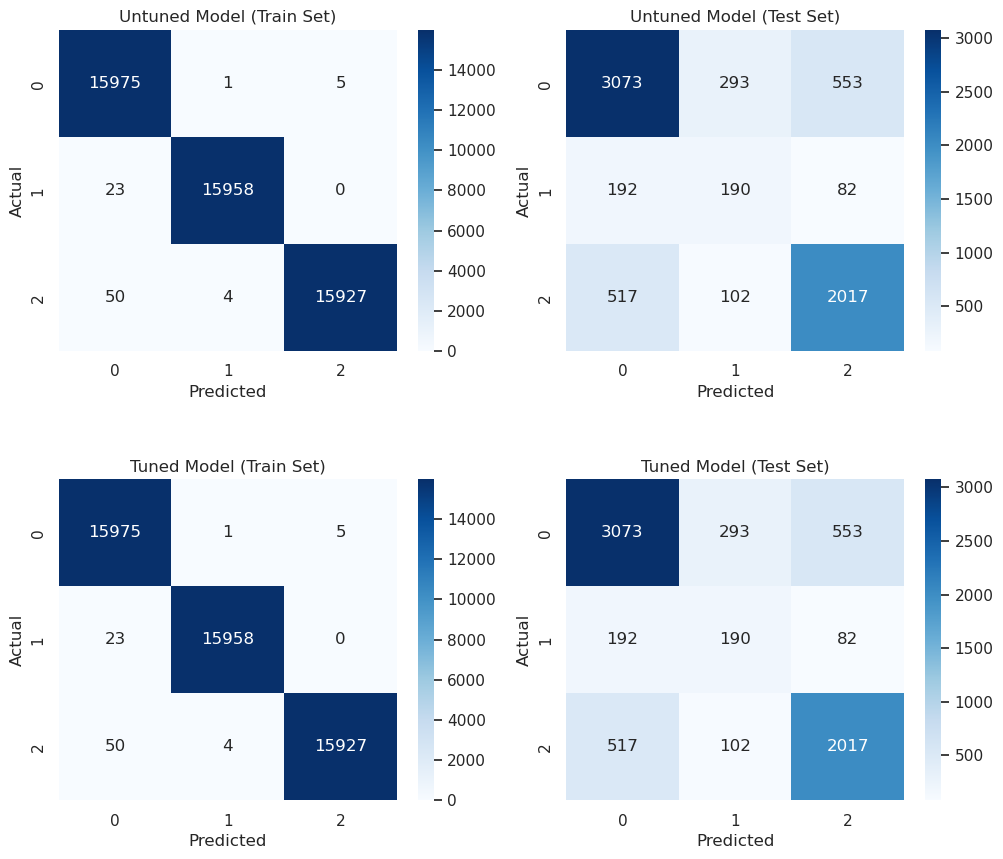

In [41]:
# Plot confusion matrices for DecisionTreeClassifier in prediciting train and test sets
cm_dt_train = confusion_matrix(y_train_balanced, y_pred_dt_train)
cm_dt_test = confusion_matrix(y_test_enc, y_pred_dt_test)
cm_dt_gs_train = confusion_matrix(y_train_balanced, y_pred_dt_gs_train)
cm_dt_gs_test = confusion_matrix(y_test_enc, y_pred_dt_gs)

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot untuned decision tree - train set
sns.heatmap(cm_dt_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Untuned Decision Tree (Train Set)')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# Plot untuned decision tree - test set
sns.heatmap(cm_dt_test, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Untuned  Decision Tree (Test Set)')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Plot tuned decision tree - train set
sns.heatmap(cm_dt_gs_train, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Tuned Decision Tree (Train Set)')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Plot tuned decision tree - test set
sns.heatmap(cm_dt_gs_test, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Tuned  Decision Tree- (Test Set)')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

# Insert vertical and horizontal spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.2) 

# Save figure to images directory and show plot
plt.savefig("./images/confusion_matrices-decision-tree-classifier.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

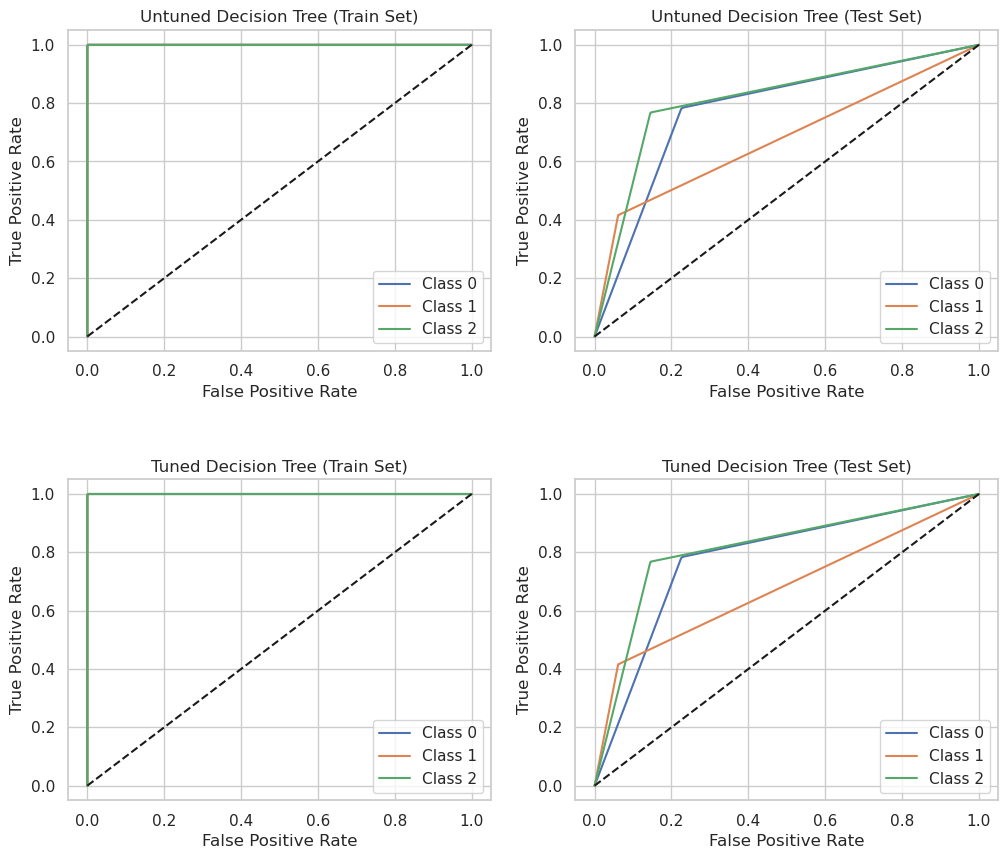

In [42]:
# Plot ROC Curves for DecisionTreeClassifier in predicting train and test sets
from sklearn.preprocessing import label_binarize

# Binarize the labels
n_classes = len(np.unique(y_train_balanced))
y_train_bin = label_binarize(y_train_balanced, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ROC Curves for Untuned Decision Tree - Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_dt_train[:, i])
    axes[0, 0].plot(fpr, tpr, label=f'Class {i}')
axes[0, 0].plot([0, 1], [0, 1], 'k--')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('Untuned Decision Tree (Train Set)')
axes[0, 0].legend()

# ROC Curves for Untuned Decision Tree - Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt_test[:, i])
    axes[0, 1].plot(fpr, tpr, label=f'Class {i}')
axes[0, 1].plot([0, 1], [0, 1], 'k--')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('Untuned Decision Tree (Test Set)')
axes[0, 1].legend()

# ROC Curves for Tuned Decision Tree - Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_dt_gs_train[:, i])
    axes[1, 0].plot(fpr, tpr, label=f'Class {i}')
axes[1, 0].plot([0, 1], [0, 1], 'k--')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Tuned Decision Tree (Train Set)')
axes[1, 0].legend()

# ROC Curves for Tuned Decision Tree - Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt_gs[:, i])
    axes[1, 1].plot(fpr, tpr, label=f'Class {i}')
axes[1, 1].plot([0, 1], [0, 1], 'k--')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('Tuned Decision Tree (Test Set)')
axes[1, 1].legend()

# Insert vertical and horizontal spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.2) 

# Save figure to images directory and show plot
plt.savefig("./images/roc-curves-decision-tree-classifier.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [43]:
# Compute metrics for Untuned Decision Tree Classifier
acc_dt_train = accuracy_score(y_train_balanced, y_pred_dt_train)
f1_dt_train = f1_score(y_train_balanced, y_pred_dt_train, average='weighted')
roc_auc_dt_train = roc_auc_score(y_train_balanced, y_proba_dt_train, multi_class='ovr')

acc_dt_test = accuracy_score(y_test_enc, y_pred_dt_test)
f1_dt_test = f1_score(y_test_enc, y_pred_dt_test, average='weighted')
roc_auc_dt_test = roc_auc_score(y_test_enc, y_proba_dt_test, multi_class='ovr')

# Compute metrics for Tuned Decision Tree Classifier
acc_dt_gs_train = accuracy_score(y_train_balanced, y_pred_dt_gs_train)
f1_dt_gs_train = f1_score(y_train_balanced, y_pred_dt_gs_train, average='weighted')
roc_auc_dt_gs_train = roc_auc_score(y_train_balanced, y_proba_dt_gs_train, multi_class='ovr')

acc_dt_gs_test = accuracy_score(y_test_enc, y_pred_dt_gs)
f1_dt_gs_test = f1_score(y_test_enc, y_pred_dt_gs, average='weighted')
roc_auc_dt_gs_test = roc_auc_score(y_test_enc, y_proba_dt_gs, multi_class='ovr')

# Create DataFrame with metrics
dt_metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_dt_train, acc_dt_gs_train],
    'Test Accuracy': [acc_dt_test, acc_dt_gs_test],
    'Train F1-score': [f1_dt_train, f1_dt_gs_train],
    'Test F1-score': [f1_dt_test, f1_dt_gs_test],
    'Train ROC-AUC': [roc_auc_dt_train, roc_auc_dt_gs_train],
    'Test ROC-AUC': [roc_auc_dt_test, roc_auc_dt_gs_test]})

# Set the index to 'Model'
dt_metrics_df.set_index('Model', inplace=True)

dt_metrics_df

,Train Accuracy,Test Accuracy,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,
Untuned Model,0.998269,0.752244,0.998269,0.756041,0.999997,0.755808
Tuned Model,0.998269,0.752244,0.998269,0.756041,0.999997,0.755808


#### Model Performance Interpretation: Untuned vs. Tuned Decision Tree

- All the performance metrics for the untuned and tuned Decision Tree Classifier are equal. The performance metrics on the the train set are approximately 100% indicating the model overfits the training data. The performance metrics on the test set are about 75%. The 25% difference confirms that the Decision Tree Classifier generalizes poorly to unseen data. 

**Limitations:** Decision Trees can easily overfit the training data, especially with many features or when the tree is deep, leading to poor generalization. Small changes in the data can result in very different tree structures, making the model less robust. Additionally, a single tree classifier is limited in capturing complex, non-linear relationships as effectively as ensemble methods. Thus, building a Gradient Boosting Classifier is necessary to achieve higher accuracy, better generalization, and improved performance on all classes in this ternary classification problem.

### 3.4 Ensemble-Boosting Model (GradientBoostingClassifier)

Ensemble-boostig models fit a number of randomized decision trees on various sub-samples of the training datasets. A Gradient Boosting Classifier is an ensemble method since the modelled decision trees are build sequentially. Each new tree in the sequence is trained to correct the errors made by the sum of previously built trees. Such an iterative error-correction algorithm gradually improves a model's overall performance, reduces bias and minimizes variance across its predictions. Implementing a Gradient Boosting Classifier is necessary since ensemble models:
- Reduce overfitting by combining multiple trees and using regularization.
- Improve predictive accuracy, especially for complex, non-linear relationships.
- Handle class imbalance and minority class prediction better through boosting.
- Are more robust and stable than a single decision tree.


In [44]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting model on balanced data
gb_bal = GradientBoostingClassifier(random_state=42)
gb_bal.fit(X_train_balanced, y_train_balanced)

# Predict on train and test sets
y_pred_gb_train = gb_bal.predict(X_train_balanced)
y_proba_gb_train = gb_bal.predict_proba(X_train_balanced)
y_pred_gb_test = gb_bal.predict(X_test_final)
y_proba_gb_test = gb_bal.predict_proba(X_test_final)

In [45]:
# Define parameter grid for tuning the GradientBoostingClassifier hyperparameters
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None],
}

# Initialize GridSearchCV
gs_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Fit on balanced training data
gs_gb.fit(X_train_balanced, y_train_balanced)
print(f"Best Gradient Boosting params: {gs_gb.best_params_}")

Best Gradient Boosting params: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': None, 'n_estimators': 200, 'subsample': 0.8}


In [46]:
# Predict on train and test sets
y_pred_gb_rs_train = gs_gb.predict(X_train_balanced)
y_proba_gb_rs_train = gs_gb.predict_proba(X_train_balanced)
y_pred_gb_rs = gs_gb.predict(X_test_final)
y_proba_gb_rs = gs_gb.predict_proba(X_test_final)

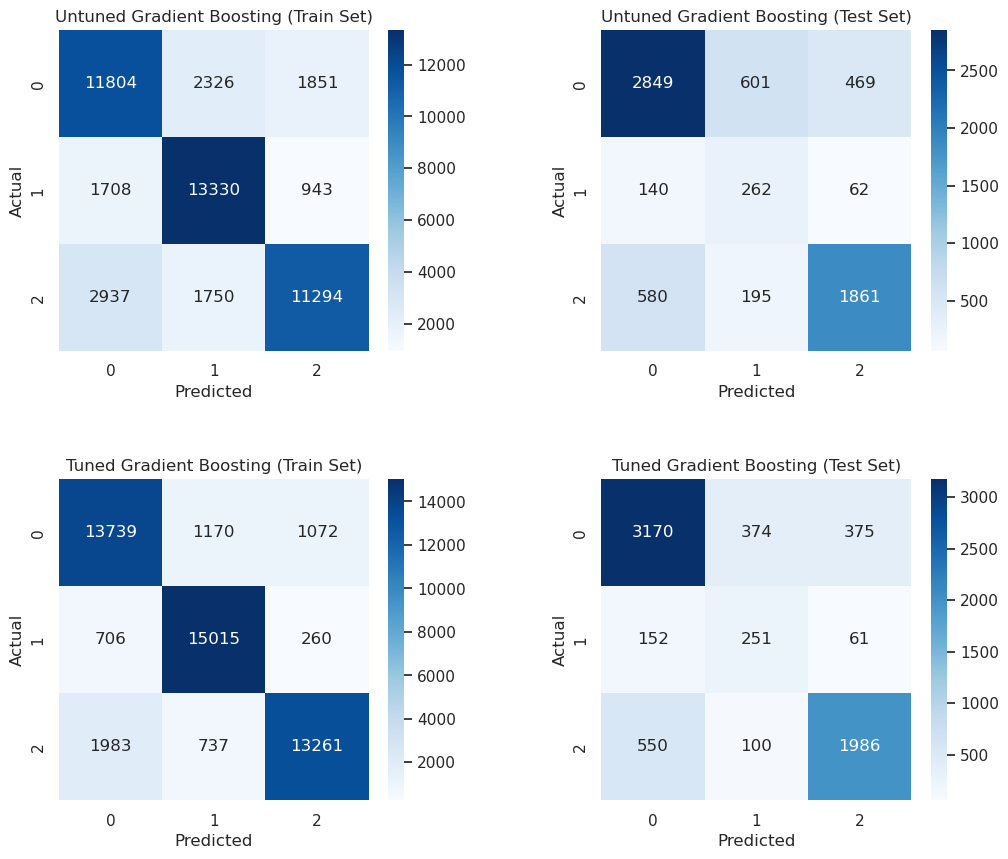

In [47]:
# Plot confusion matrices for GradientBoostingClassifier on train and test sets
cm_gb_train = confusion_matrix(y_train_balanced, y_pred_gb_train)
cm_gb_test = confusion_matrix(y_test_enc, y_pred_gb_test)
cm_train_gb_rs = confusion_matrix(y_train_balanced, y_pred_gb_rs_train)
cm_test_gb_rs = confusion_matrix(y_test_enc, y_pred_gb_rs)

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot untuned Gradient Boosting - Train Set
sns.heatmap(cm_gb_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Untuned Gradient Boosting (Train Set)')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# Plot untuned Gradient Boosting - Test Set
sns.heatmap(cm_gb_test, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Untuned Gradient Boosting (Test Set)')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Plot tuned Gradient Boosting - Train Set
sns.heatmap(cm_train_gb_rs, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Tuned Gradient Boosting (Train Set)')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Plot tuned Gradient Boosting - Test Set
sns.heatmap(cm_test_gb_rs, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Tuned Gradient Boosting (Test Set)')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

# Add vertical and horizontal spacing
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# Save figure to images directory and display plot
plt.savefig("./images/confusion-matrices-gradient-boosting-classifier.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

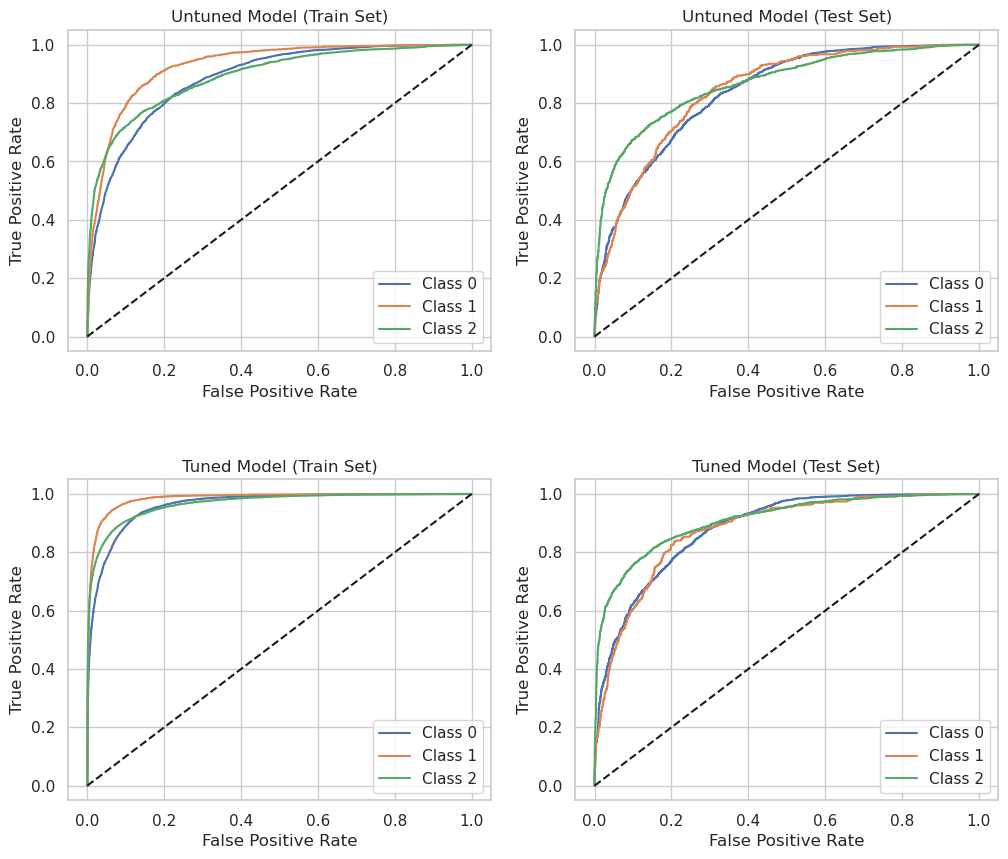

In [48]:
# Plot ROC curves for GradientBoostingClassifier on train and test sets

# Binarize the labels
n_classes = len(np.unique(y_train_balanced))
y_train_bin = label_binarize(y_train_balanced, classes=range(n_classes))
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ROC Curves for Untuned Gradient Boosting - Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gb_train[:, i])
    axes[0, 0].plot(fpr, tpr, label=f'Class {i}')
axes[0, 0].plot([0, 1], [0, 1], 'k--')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('Untuned Gradient Boosting (Train Set)')
axes[0, 0].legend()
axes[0, 0].grid(True)

# ROC Curves for Untuned Gradient Boosting - Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gb_test[:, i])
    axes[0, 1].plot(fpr, tpr, label=f'Class {i}')
axes[0, 1].plot([0, 1], [0, 1], 'k--')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('Untuned Gradient Boosting (Test Set)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# ROC Curves for Tuned Gradient Boosting - Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gb_rs_train[:, i])
    axes[1, 0].plot(fpr, tpr, label=f'Class {i}')
axes[1, 0].plot([0, 1], [0, 1], 'k--')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Tuned Gradient Boosting (Train Set)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# ROC Curves for Tuned Gradient Boosting - Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gb_rs[:, i])
    axes[1, 1].plot(fpr, tpr, label=f'Class {i}')
axes[1, 1].plot([0, 1], [0, 1], 'k--')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('Tuned Gradient Boosting (Test Set)')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Add vertical and horizontal spacing
plt.subplots_adjust(hspace=0.4, wspace=0.2)  

# Save figure to images directory and display plot
plt.savefig("./images/roc-curves-gradient-boosting-classifier.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [54]:
# Compute performance metrics for untuned GradientBoostingClassifier
acc_gb_train = accuracy_score(y_train_balanced, y_pred_gb_train)
f1_gb_train = f1_score(y_train_balanced, y_pred_gb_train, average='weighted')
roc_auc_gb_train = roc_auc_score(y_train_balanced, y_proba_gb_train, multi_class='ovr')
acc_gb_test = accuracy_score(y_test_enc, y_pred_gb_test)
f1_gb_test = f1_score(y_test_enc, y_pred_gb_test, average='weighted')
roc_auc_gb_test = roc_auc_score(y_test_enc, y_proba_gb_test, multi_class='ovr')
                                
                                 
# Compute performance metrics for tuned GradientBoostingClassifier
acc_gb_rs_train = accuracy_score(y_train_balanced, y_pred_gb_rs_train)
f1_gb_rs_train = f1_score(y_train_balanced, y_pred_gb_rs_train, average='weighted')
roc_auc_gb_rs_train = roc_auc_score(y_train_balanced, y_proba_gb_rs_train, multi_class='ovr')                          
acc_gb_rs_test = accuracy_score(y_test_enc, y_pred_gb_rs)
f1_gb_rs_test = f1_score(y_test_enc, y_pred_gb_rs, average='weighted')
roc_auc_gb_rs_test = roc_auc_score(y_test_enc, y_proba_gb_rs, multi_class='ovr')

                                 
# Create DataFrame with metrics
gb_metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_gb_train, acc_gb_rs_train],
    'Test Accuracy': [acc_gb_test, acc_gb_rs_test],
    'Train F1-score': [f1_gb_train, f1_gb_rs_train],
    'Test F1-score': [f1_gb_test, f1_gb_rs_test],
    'Train ROC-AUC': [roc_auc_gb_train, roc_auc_gb_rs_train],
    'Test ROC-AUC': [roc_auc_gb_test, roc_auc_gb_rs_test]
})

# Set the index to 'Model'
gb_metrics_df.set_index('Model', inplace=True)

gb_metrics_df

,Train Accuracy,Test Accuracy,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,
Untuned Model,0.759819,0.708363,0.759229,0.725634,0.902194,0.850073
Tuned Model,0.876353,0.770338,0.876001,0.777184,0.971252,0.889499


#### Model Performance Interpretation: Untuned vs. Tuned Gradient Boosting Classifier

The tuned Gradient Boosting Classifier outperforms the untuned version across all metrics on both the training and test sets.

- **F1-score:** Untuned model achieves approximately 0.76 (train) and 0.73 (test), while the tuned model improves to 0.88 (train) and 0.78 (test), indicating better balance between precision and recall after tuning.

- **Accuracy:** Untuned model achieves an accuracy score of about 76% on the training set and 71% on (test). For the tuned classifier; the accuracy improves to around 88% (train) and 77% (test).

- **ROC-AUC:** Tuned model achieves a score of approximately 0.90 (train) and 0.85 (test), compared to 0.91 (train) and 0.89 (test) for the untuned model.

**Limitation:** Since boosting ensemble algorithms aim to correct errors; GradientBoostingClassifiers can overfit to noise or outliers in the training set by focusing too much on difficult-to-classify instances.

### 3.6 Ensemble-Bagging Model (RandomForestClassifier)

A Random Forest Classifier fits a number of randomized decision trees on various sub-samples of the training dataset and uses averaging to improve predictive accuracy and control overfitting. Unlike Gradient Boosting, where trees are built sequentially to correct previous errors; each tree in a Random Forest is independent. 
- Random Forest classifiers are less susceptible to outliers.
- Random Forest allows for feature importance analysis.

In [55]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the untuned Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Train the Random Forest Classifier on the balanced training data
rf.fit(X_train_balanced, y_train_balanced)

# Predict on train and test sets
y_pred_rf_train = rf.predict(X_train_balanced)
y_proba_rf_train = rf.predict_proba(X_train_balanced)
y_pred_rf_test = rf.predict(X_test_final)
y_proba_rf_test = rf.predict_proba(X_test_final)

In [56]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [200, 300, 400],
    'max_depth': [40, 50, 100],
    'min_samples_split': [5, 10, 20],
    'max_features': ['sqrt', 'log2', None],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid_rf,
                           cv=5,
                           n_jobs=-1,
                           scoring='f1_macro')

# Train the GridSearchCV object on the balanced training data
grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best parameters
best_params_rf = grid_search.best_params_

# Initialize the tuned Random Forest Classifier with the best parameters
rf_tuned = RandomForestClassifier(**best_params_rf, random_state=42)

# Train the tuned Random Forest Classifier on the balanced training data
rf_tuned.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(max_depth=100, max_features='log2', min_samples_split=5,
                       n_estimators=400, random_state=42)

In [57]:
# Predict on train and test sets
y_pred_rf_tuned_train = rf_tuned.predict(X_train_balanced)
y_proba_rf_tuned_train = rf_tuned.predict_proba(X_train_balanced)
y_pred_rf_tuned_test = rf_tuned.predict(X_test_final)
y_proba_rf_tuned_test = rf_tuned.predict_proba(X_test_final)

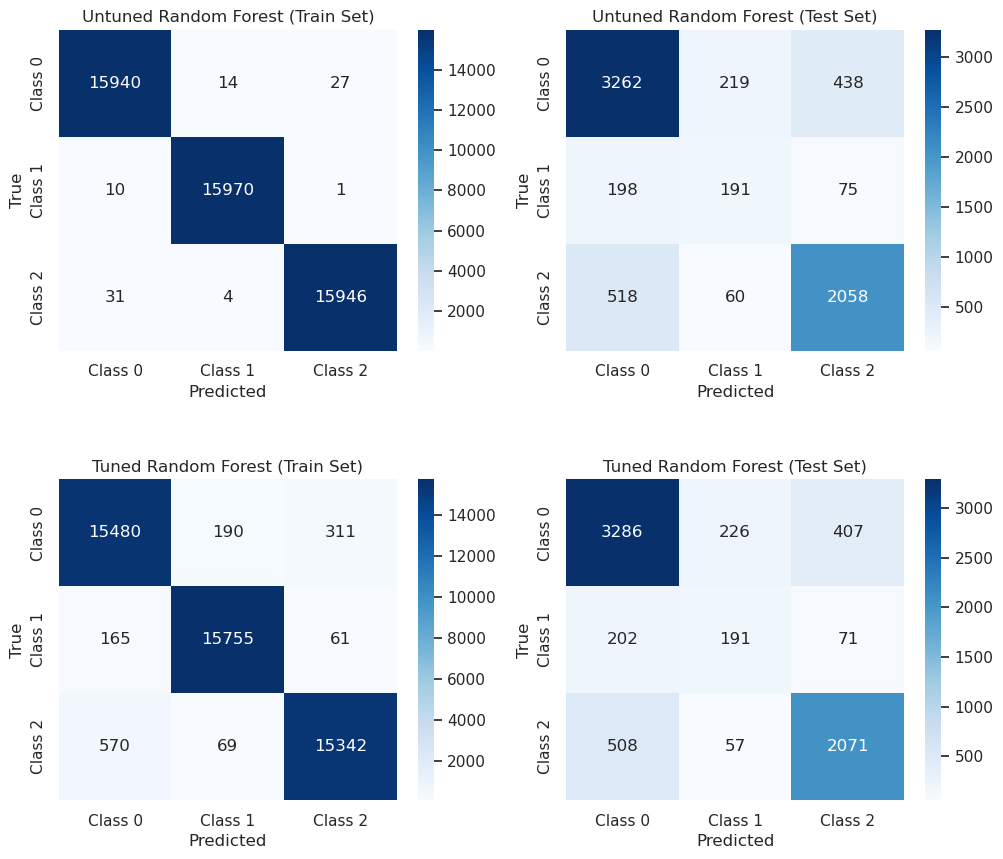

In [58]:
# Compute confusion matrices
cm_rf_train = confusion_matrix(y_train_balanced, y_pred_rf_train)
cm_rf_test = confusion_matrix(y_test_enc, y_pred_rf_test)
cm_rf_cv_train = confusion_matrix(y_train_balanced, y_pred_rf_tuned_train)
cm_rf_cv_test = confusion_matrix(y_test_enc, y_pred_rf_tuned_test)

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot untuned Random Forest - Train Set
sns.heatmap(cm_rf_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
axes[0, 0].set_title('Untuned Random Forest (Train Set)')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')

# Plot untuned Random Forest - Test Set
sns.heatmap(cm_rf_test, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
axes[0, 1].set_title('Untuned Random Forest (Test Set)')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')

# Plot tuned Random Forest - Train Set
sns.heatmap(cm_rf_cv_train, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
axes[1, 0].set_title('Tuned Random Forest (Train Set)')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')

# Plot tuned Random Forest - Test Set
sns.heatmap(cm_rf_cv_test, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
axes[1, 1].set_title('Tuned Random Forest (Test Set)')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

# Add vertical and horizontal spacing
plt.subplots_adjust(hspace=0.4, wspace=0.2) 

# Save figure to images directory and display plot
plt.savefig("./images/confusion-matrices-random-forest-classifier.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

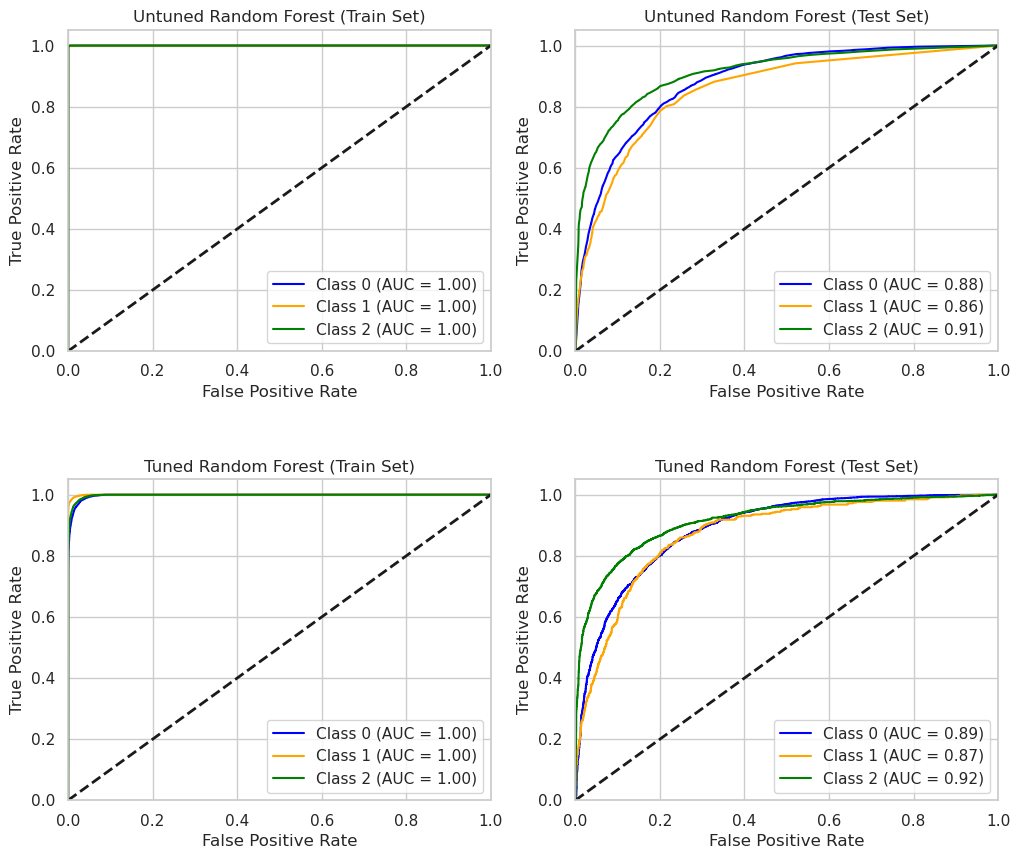

In [59]:
# Plot ROC curves for the RandomForestClassifier on both train and test

# Binarize the labels
n_classes = len(np.unique(y_train_balanced))
classes = [0, 1, 2]  # Ternary classes
y_train_bin = label_binarize(y_train_balanced, classes=classes)
y_test_bin = label_binarize(y_test_enc, classes=classes)

# Colors for each class
colors = ['blue', 'orange', 'green']

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ROC Curves for Untuned Random Forest - Train Set
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_rf_train[:, i])
    auc = roc_auc_score(y_train_bin[:, i], y_proba_rf_train[:, i])
    axes[0, 0].plot(fpr, tpr, color=color, label=f'Class {i} (AUC = {auc:.2f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('Untuned Random Forest (Train Set)')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(True)

# ROC Curves for Untuned Random Forest - Test Set
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_rf_test[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_proba_rf_test[:, i])
    axes[0, 1].plot(fpr, tpr, color=color, label=f'Class {i} (AUC = {auc:.2f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('Untuned Random Forest (Test Set)')
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(True)

# ROC Curves for Tuned Random Forest - Train Set
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_rf_tuned_train[:, i])
    auc = roc_auc_score(y_train_bin[:, i], y_proba_rf_tuned_train[:, i])
    axes[1, 0].plot(fpr, tpr, color=color, label=f'Class {i} (AUC = {auc:.2f})')
axes[1, 0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Tuned Random Forest (Train Set)')
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(True)

# ROC Curves for Tuned Random Forest - Test Set
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_rf_tuned_test[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_proba_rf_tuned_test[:, i])
    axes[1, 1].plot(fpr, tpr, color=color, label=f'Class {i} (AUC = {auc:.2f})')
axes[1, 1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('Tuned Random Forest (Test Set)')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(True)

# Add vertical and horizontal spacing
plt.subplots_adjust(hspace=0.4, wspace=0.2) 

# Save figure to images directory and display plot
plt.savefig("./images/roc-curves-random-forest-classifier.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [60]:
# Compute performance metrics for untuned and tuned Random Forest Classifier

# Evaluate performance on train and test set for untuned Random Forest model
acc_rf_train = accuracy_score(y_train_balanced, y_pred_rf_train)
f1_rf_train = f1_score(y_train_balanced, y_pred_rf_train, average='weighted')
# Binarize labels for ROC-AUC (OvR)
y_train_bin = label_binarize(y_train_balanced, classes=[0, 1, 2])
roc_auc_rf_train = roc_auc_score(y_train_bin, y_proba_rf_train, multi_class='ovr', average='weighted')

acc_rf_test = accuracy_score(y_test_enc, y_pred_rf_test)
f1_rf_test = f1_score(y_test_enc, y_pred_rf_test, average='weighted')
# Binarize labels for ROC-AUC (OvR)
y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])
roc_auc_rf_test = roc_auc_score(y_test_bin, y_proba_rf_test, multi_class='ovr', average='weighted')

# Evaluate performance on train and test set for tuned Random Forest model
acc_rf_tuned_train = accuracy_score(y_train_balanced, y_pred_rf_tuned_train)
f1_rf_tuned_train = f1_score(y_train_balanced, y_pred_rf_tuned_train, average='weighted')
# Binarize labels for ROC-AUC (OvR)
roc_auc_rf_tuned_train = roc_auc_score(y_train_bin, y_proba_rf_tuned_train, multi_class='ovr', average='weighted')

acc_rf_tuned_test = accuracy_score(y_test_enc, y_pred_rf_tuned_test)
f1_rf_tuned_test = f1_score(y_test_enc, y_pred_rf_tuned_test, average='weighted')
# Binarize labels for ROC-AUC (OvR)
roc_auc_rf_tuned_test = roc_auc_score(y_test_bin, y_proba_rf_tuned_test, multi_class='ovr', average='weighted')

# Create a DataFrame with metrics for both untuned and tuned Random Forest
metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_rf_train, acc_rf_tuned_train],
    'Test Accuracy': [acc_rf_test, acc_rf_tuned_test],
    'Train F1-score': [f1_rf_train, f1_rf_tuned_train],
    'Test F1-score': [f1_rf_test, f1_rf_tuned_test],
    'Train ROC-AUC': [roc_auc_rf_train, roc_auc_rf_tuned_train],
    'Test ROC-AUC': [roc_auc_rf_test, roc_auc_rf_tuned_test]
})

metrics_df.set_index('Model', inplace=True)
metrics_df

,Train Accuracy,Test Accuracy,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,
Untuned Model,0.998185,0.785155,0.998185,0.785168,0.999981,0.892047
Tuned Model,0.971508,0.790426,0.971518,0.790532,0.998519,0.897939


#### Model Performance Interpretation: Untuned vs. Tuned Random Forest Classifier

The tuned Random Forest Classifier outperforms the untuned version across all metrics on the test set but consistently scores lower on the train set.

- **F1-score:** Untuned model achieves approximately 1.0 (train) and 0.70 (test), while the tuned model scores about 0.93 (train) and 0.71 (test), indicating better balance between precision and recall after tuning.

- **Accuracy:** Untuned model achieves an accuracy score of about 100% on the training set and approximately 68% on (test). For the tuned classifier; the model scores around 93% (train) and improves to 69% on the test set.

- **ROC-AUC:** Tuned model achieves a score of approximately 0.99 (train) and 0.86 (test), compared to 1.0 (train) and around 0.84 (test) for the untuned model.

Unlike the tuned Gradient Boosting model; the tuned Random Forests Classifier registers improvements only on the test set across the three performance metrics. 

## 4 Model Evaluation

### 4.1 Performance Metrics Comparison (on train set and test set)
This section compares the respective performance metrics (**Accuracy**, **F1-score**, and **ROC-AUC**) for the tuned models. When tuning the hyperparameters of the three models; **scoring** was set to 'f1_macro' in GridSearchCV to ensure the algorithm prioritized finding the model configuration that maximized the macro-averaged **F1-score**. Hence, the **F1-score** of each class regardless of its size contributed equally to the overall 'f1_macro' score. Consequently, the best set of hyperparameters for each tuned model was one that resulted in the highest 'f1_macro' during cross-validation.   

 The insights deduced from these comparisons are vital in supporting data-driven decisions on the best-fit/ most-appropriate supervised ML classifier for deployment. The best model is selected based on performance metrics and generalizability. A precise and sensitive model is crucial in optimizing the operational effectiveness of NGO's focused on locating wells in need of maintenance/ repairs. Additionally, a generalizable model will support the Tanzanian Government in extrapolating patterns for non-functional wells to make better-informed, data-supported decisions on the framework for designing, planning, and implementing new ground water infrastructure. 

In [61]:
# Compare the performance for all the models (tuned and untuned classifiers)
all_metrics_df = pd.DataFrame({
    'Model': ['Tuned Decision Tree', 
              'Tuned Gradient Boosting',
              'Tuned Random Forest'],
    'Train Accuracy': [acc_dt_gs_train, acc_gb_rs_train, acc_rf_tuned_train],
    'Test Accuracy': [acc_dt_gs_test, acc_gb_rs_test, acc_rf_tuned_test],
    'Train F1-score': [f1_dt_gs_train, f1_gb_rs_train, f1_rf_tuned_train],
    'Test F1-score': [f1_dt_gs_test, f1_gb_rs_test, f1_rf_tuned_test],
    'Train ROC-AUC': [roc_auc_dt_gs_train, roc_auc_gb_rs_train, roc_auc_rf_tuned_train],
    'Test ROC-AUC': [roc_auc_dt_gs_test, roc_auc_gb_rs_test, roc_auc_rf_tuned_test]
})

all_metrics_df

,Model,Train Accuracy,Test Accuracy,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
0,Tuned Decision Tree,0.998269,0.752244,0.998269,0.756041,0.999997,0.755808
1,Tuned Gradient Boosting,0.876353,0.770338,0.876001,0.777184,0.971252,0.889499
2,Tuned Random Forest,0.971508,0.790426,0.971518,0.790532,0.998519,0.897939


- **Decision Tree**: The performance metrics on the the training set are approximately 100% and 75% (test). _The model overfits the training data and generalizes poorly to unseen data._ 

- **Gradient Boosting**: The accuracy on the training set are 87.6% (train) and 77% (test). The F-1 score on the training set is around 0.87 and 0.78 on the test set indicating the that the model strikes an effective balance between precision and recall. The ROC-AUC (train) is 0.97 and 0.89 on the testing set justifying the model's generalizability to unseen data.

- **Random Forest**: The accuracy on the train set is approximately 97% and 79% on the test set alluding the model overfits the training data. The F-1 score is around 0.97(train) and 0.79 (test) The train ROC-AUC is about 1.0 and the test metric is around 0.9. 

**Best Model Per Performance Metrics on the Train-set and Test-set :** Although the **_tuned Random Forest Classifier_** achives higher scores across the three performance metrics on the test-set; the respective gap compared to its scores on the train-set allude the model is overfitting the training data. An overfitted supervised ML classifier on the training set is likelier to generalize poorly to unseen data. This notion is justified by calling the tuned versions of the three models to predict the functional status of water-wells in Tanzania based on the features provided in the **_testdata.csv_** dataset.


### 4.2 Prediction Accuracy on the testdata.csv Dataset

The evaluation dataset is loaded from the **testdata.csv** dataset and prepared for prediction per the previously modularized data preprocessing pipeline.

In [62]:
# Load test dataset
test_features = pd.read_csv('./data/testdata.csv')

# Display first five rows of the test set
test_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [63]:
# Check shape
test_features.shape

(14850, 40)

In [64]:
# Preprocess the evaluation dataset features per the preprocessing pipeline
evaluation_df = test_features.copy()

# 1. Drop irrelevant columns
evaluation_df = evaluation_df.loc[:, picked_cols]

# 2. Engineer the `well_age` feature and drop entries whose `well_age` is less than 0
evaluation_df['date_recorded'] = pd.to_datetime(evaluation_df['date_recorded']).dt.year
evaluation_df['well_age'] = evaluation_df['date_recorded'] - evaluation_df['construction_year']
evaluation_df = evaluation_df.drop(columns=['construction_year', 'date_recorded'])

# 3. Identify numerical and categorical features
evaluation_num_cols = evaluation_df.select_dtypes(include=[np.number]).columns.tolist()
evaluation_cat_cols = evaluation_df.select_dtypes(include=['object']).columns.tolist()

# 4. Normalize numerical features
evaluation_scaled = evaluation_df.copy()
evaluation_scaled[evaluation_num_cols] = scaler.transform(evaluation_scaled[evaluation_num_cols])
evaluation_num_df = pd.DataFrame(evaluation_scaled, columns=evaluation_num_cols, index=evaluation_scaled.index)

# 5. One-hot encode categorical features
test_cat_features = ohe.transform(evaluation_scaled[evaluation_cat_cols])
test_cat_feature_names = ohe.get_feature_names_out(evaluation_cat_cols)
evaluation_ohe_df = pd.DataFrame(test_cat_features, columns=test_cat_feature_names, index=evaluation_scaled.index)

# 6. Concat normalized numerical features and OneHot encoded cataegorical features
evaluation_df_final = pd.concat([evaluation_num_df, evaluation_ohe_df], axis=1)

# Check model valuation dataset shape
evaluation_df_final.shape
print(f"Evaluation dataset consists of: {evaluation_df_final.shape[0]} rows")
print(f"Evaluation dataset consists of: {evaluation_df_final.shape[1]} columns")

Evaluation dataset consists of: 14850 rows
Evaluation dataset consists of: 1342 columns


- Predict the `status_group` of entries in the testdata.csv dataset using the **tuned Gradient Boosting Classifier**, and the **tuned Random Forest Classifier**.

In [67]:
# Predictions using the tuned Decision Tree Classifier
test_predictions_decisiontree = gs_dt.predict(evaluation_df_final)
submission_decisiontree = pd.DataFrame({
    'id': test_features['id'],
    'status_group': le.inverse_transform(test_predictions_decisiontree)})

# Predictions using the tuned Gradient Boosting Classifier
test_predictions_gradientboosting = gs_gb.predict(evaluation_df_final)
submission_gradientboosting = pd.DataFrame({
    'id': test_features['id'],
    'status_group': le.inverse_transform(test_predictions_gradientboosting)})

# Predictions using the tuned Random Forest Classifier
test_predictions_randomforest = rf_tuned.predict(evaluation_df_final)
submission_randomforest = pd.DataFrame({
    'id': test_features['id'],
    'status_group': le.inverse_transform(test_predictions_randomforest)})

- The three DataFrames holding the predictions made by classifier are exported to the data directory as .csv files. 

In [68]:
# Save the submission DataFrames to CSV files in the data directory
submission_decisiontree.to_csv('./data/final-submission-decisiontree.csv', index=False)
submission_gradientboosting.to_csv('./data/final-submission-gradientboosting.csv', index=False)
submission_randomforest.to_csv('./data/final-submission-randomforest.csv', index=False)

- The .csv files were submitted for prediction accuracy scoring on the **DrivenData submissions** tab https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/submissions/

- The prediction accuracy percentages for the three models are captured in the table below are captured in the table below. 

| Model | Prediction Accuracy Percentage |
|----------|----------|
| Tuned Decision Tree Classifier | 67.54% | 
| Tuned Gradient Boosting Classifier | 71.06% | 
| Tuned Random Forest Classifier | 70.77% | 

- Per the prediction accuracy scores; it is evident that the tuned Gradient Boosting Classifier outperforms the Random Forest Classifier by 0.29%. This slight difference justifies the superiority, and better generalizability of the **Tuned Gradient Boosting Classifier** in predicting the functional status of a water-well in Tanzania.

### 4.3 Selected Model

Based on the evaluation, the tuned Gradient Boosting Classifier is the best choice for deployment. 
1. The model delivers superior predictive performance, strikes an effective balance on _**Precision**_ and _**Recall**_ across all the three classses of the target variable (_highest f1-score_).
2. The classifier generalizes well to unseen data (_highest ROC-AUC_). 
2. The performance metrics; (train) and (test) for the tuned Gradient Boosting Classifiers are close. The minimal variance affirms that the model does not overfit the training data. 
3. The prediction accuracy for the tuned Gradient Boosting Classifier is the highest (71.97%) on the evaluation dataset (**_testdata.csv_**).  
- Thus, the **tuned Gradient Boosting Classifier** is recommended for deployment.

### 4.4 Feature Importance

A RandomForestClassifier is trained to determine **Feature Importances**

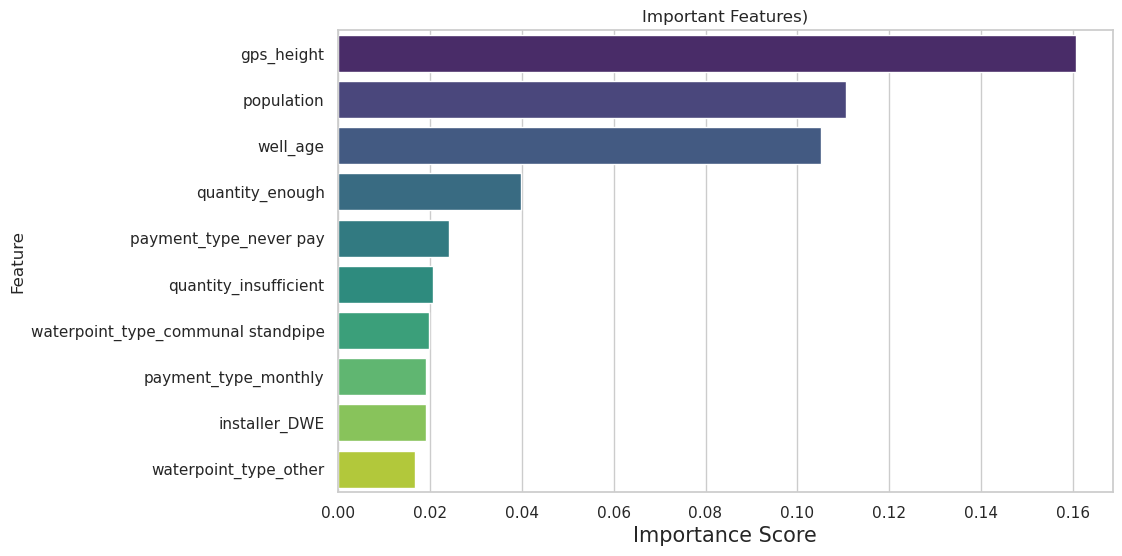

In [71]:
# Train a RandomForest model to compute feature importances
rf_important = RandomForestClassifier(random_state=42)
rf_important.fit(X_train_balanced, y_train_balanced)

# Get feature importances
feature_importances = rf_important.feature_importances_
importance_df = pd.DataFrame({'Feature':X_train_balanced.columns, 'Importance':feature_importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot top-15 important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Importance Score', fontsize=15)
plt.ylabel('Feature')
plt.title('Important Features)')

# Save plot to images folder
plt.savefig("./images/important-features.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

Per the **_important-features_** plot; it is evident that `gps_height`, `population`, and `well_age` are the most significant predictors for a water-well's functional status. Other features that have a substantial influence include: `quantity`, `payment_type`, `waterpoint_type`, `payment_type`, and `installer`.

## 5 Conclusion, and Recommendations

### 5.1 Conclusion

The analysis of the Tanzanian water-wells' dataset demonstrates that supervised machine learning models can effectively predict the functional status of water wells using historical and engineered features. The hyperparameter-tuned Gradient Boosting Classifier consistently outperformed baseline Decision Tree model, and the Random Forest Classifier. The Ensemble-boosting model scored the highest **_f1_score_**, and **_ROC-AUC_** scores on the test set. Additionally, these performance metrics for the tuned model had the least variance between the training set and the test set justifying the model's high generalizability. The confusion matrices and ROC curves for the model justified its relatively stronger predictive power and robustness in generalizing to unseen data. These findings are backed up by its prediction accuracy percentage **(71.06%)** on the **_testdata.csv_** dataset solidifying the superiority of the Gradient Boosting Classifier in predicitng the target variable based on the modeled features. Therefore, the tuned Gradient Boosting Classifier is recommended for deployment due to its superior accuracy, balanced performance across all classes, and robustness against overfitting. 

### 5.2 Recommendations
1. The top-three predictors per the featur-importance plot are `gps_height`, `population`, and `well_age`. Hence, when collecting/ updating data on water-wells in future; these features must be prioritized for inclusion in the training set.  

2. Maintenance and resource allocation efforts must prioritize wells that are older, utilize less reliable extraction types, or are located in regions with historically higher rates of non-functionality. Monitoring and proactive intervention for these high-risk wells can help improve water access and reduce downtime.

3. The Tanzanian Government and NGO's funding the water-well projects should prioritize contracting installers with a proven track record (higher percentages/ counts for functional wells) such as COMMU and DANIDA as captured in the DataFrame below. 

In [72]:
# Function to trim installer names to first two words
def trim_to_two_words(name):
    if isinstance(name, str):
        words = name.split()
        return ' '.join(words[:2]) if len(words) > 2 else name
    return name

# Preprocess the 'installer' column
train_df['installer'] = train_df['installer'].str.upper().fillna('UNKNOWN')  # Convert to uppercase and handle NaN
train_df['installer'] = train_df['installer'].apply(trim_to_two_words)  # Trim to first two words

# Standardize government-related terms
train_df['installer'] = train_df['installer'].replace({
    'CENTRAL GOVERNMENT': 'GOVERNMENT',
    'GOV': 'GOVERNMENT',
    'GOVERNMENT OF': 'GOVERNMENT',
    'CENTRAL GOVT': 'GOVERNMENT'
})

# Get value counts for each status group and exclude 'UNKNOWN'
functional_installers = train_df[train_df['status_group'] == 'functional']['installer'].value_counts()
functional_installers = functional_installers[functional_installers.index != 'UNKNOWN'].head()

non_functional_installers = train_df[train_df['status_group'] == 'non functional']['installer'].value_counts()
non_functional_installers = non_functional_installers[non_functional_installers.index != 'UNKNOWN'].head()

functional_needs_repair_installers = train_df[train_df['status_group'] == 'functional needs repair']['installer'].value_counts()
functional_needs_repair_installers = functional_needs_repair_installers[functional_needs_repair_installers.index != 'UNKNOWN'].head()

# Create a DataFrame with installers as index and counts for each status
installers_df = pd.DataFrame({
    'Functional': functional_installers,
    'Non Functional': non_functional_installers,
    'Functional Needs Repair': functional_needs_repair_installers
})

# Fill NaN values with 0 and convert to integers
installers_df = installers_df.fillna(0).astype(int)

# Reset index to make 'installer' a column
installers_df = installers_df.reset_index().rename(columns={'index': 'installer'})
installers_df

,installer,Functional,Non Functional,Functional Needs Repair
0,COMMU,726,0,0
1,DANIDA,542,0,83
2,DISTRICT COUNCIL,0,515,0
3,DWE,9434,6349,1622
4,GOVERNMENT,793,1727,273
5,HESAWA,786,555,0
6,RWE,0,765,137
7,WORLD VISION,0,0,89


## 6 Next Steps

1. **Model Deployment**: Integrate the recommended **Tuned Gradient Boosting Classifier** model into a user-friendly dashboard for real-time predictions.

2. **Integrate Model Predictions into Maintenance Planning**: Use the model’s predictions to inform and optimize maintenance schedules, prioritizing wells identified as high-risk based on key features such as well age, extraction type, and water point type group.

3. **Pilot Targeted Interventions**: Use the model to pilot targeted maintenance or resource allocation interventions in regions or for well types identified as high-risk, and measure the impact on well functionality and service delivery.

4. **Collect and Incorporate Additional Data**: Encourage field teams to collect more granular data on well management, payment types, and environmental factors. Additional features may further improve model performance and provide deeper insights. As new data becomes available, retrain and validate the model to ensure its continued accuracy and relevance. This will help adapt to changing patterns in well functionality and environmental conditions.

